In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.signal import savgol_filter
import seaborn as sns
import random
random.seed(1)
%matplotlib inline

In [2]:
from covertrace.utils.kinase_estimation_inh import fit_params_inhibitor
from covertrace.utils.kinase_estimation_dynamics import fit_trapezoid

In [3]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [4]:
data_folder = join(dirname(dirname(dirname(abspath(os.curdir)))), 'covertrackdev', 'output')

## KTR Model

The following ordinary differential equations (ODE) models describe the dynamics of the phosphorylated/dephosphorylated reporter in nucleus/cytosol.

$\dfrac{dr_{cu}}{dt} = -kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} + k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{iu}\cdot r_{cu} + k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{nu}}{dt} = -kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} + k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{iu}\cdot r_{cu} - k_v\cdot k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{cp}}{dt} = kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} - k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{ip}\cdot r_{cp} + k_{ep}\cdot r_{np}$  
$\dfrac{dr_{np}}{dt} = kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} - k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{ip}\cdot r_{cp} - k_v\cdot k_{ep}\cdot r_{np}$  
$r_{cu} + r_{cp} + \frac{1}{k_v} (r_{nu} + r_{np}) = r_{total}$


|Symbol         |description| Units   |
|:---:            |---|:---:|
|$r_{total}$    |total concentration of reporters    |$\mu M$|
|$r_{cu}$       |cytosolic unphosphorylated reporter |$\mu M$|
|$r_{nu}$       |nuclear unphosphorylated reporter   |$\mu M$|
|$r_{cp}$       |cytosolic phosphorylated reporter   |$\mu M$|
|$r_{np}$       |nuclear phosphorylated reporter     |$\mu M$|
|$k_{iu}$       |nucler import of unphosphorylated reporter|$min^{-1}$|
|$k_{eu}$       |nucler export of unphosphorylated reporter|$min^{-1}$|
|$k_{ip}$       |nucler import of phosphorylated reporter|$min^{-1}$|
|$k_{ep}$       |nucler export of phosphorylated reporter|$min^{-1}$|
|$k_{cat}$      |catalytic rate constant of kinase and reporter |$min^{-1}$|
|$K_{m}$        |Michaelis constant for kinase and reporter |$\mu M$|
|$k_{dc}$       |dephosphorylation $V_{max}$ of reporter in cytosol |$\mu M\cdot min^{-1}$|
|$K_{md}$       |Michaelis constant for dephosphorylation of reporter |$\mu M$|
|$kin_c(t)$     |time dependent concentrations of active kinase in cytosol|$\mu M$|
|$kin_n(t)$     |time dependent concentrations of active kinase in nucleus|$\mu M$|



## Parameters from literature

r<sub>total</sub> is the total concentration of the reporter in the cell.

k<sub>cat</sub> is the rate at which the reporter gets phosphorylated by JNK.

K<sub>m</sub> is the Michaelis-Menten constant for JNK. 

r<sub>total</sub>, k<sub>cat</sub> and K<sub>m</sub> are taken from previous works. 

In [5]:
r_total = 0.4  # uM
k_cat = 20.0  # 1/min
Km = 3.0  # uM

## Estimation of cytosolic to nuclear volume ratio: k<sub>v</sub>

First obtain the parameter k<sub>v</sub>, ratio of cytosolic volume to nuclear volume. 

We assume that the total reporter concentration is constant for the time-scale of our experiments. 

Therefore, $r_{c,1} + \dfrac{r_{n,1}}{k_v} = r_{c,2} + \dfrac{r_{n,2}}{k_v}$ where $r_{c,i}$ and $r_{n,i}$ are the cytosolic and nuclear concentrations of the reporter at condition *i*.  

Solving for $k_v$, we get:  
  
$k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
A larger dynamic range in your data will give you a better signal to noise ratio, and thus a more accurate estimation of $k_v$.
For this reason, we use the condition where the JNK KTR is activated by anisomycin and then inhibited by JNK inhibitor. 

In [6]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001']
conditions = ['AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')

Take a look at the average traces for the median intensity of the cytoplasmic/nuclear (C/N) ratio. This dataset has already been cleaned.

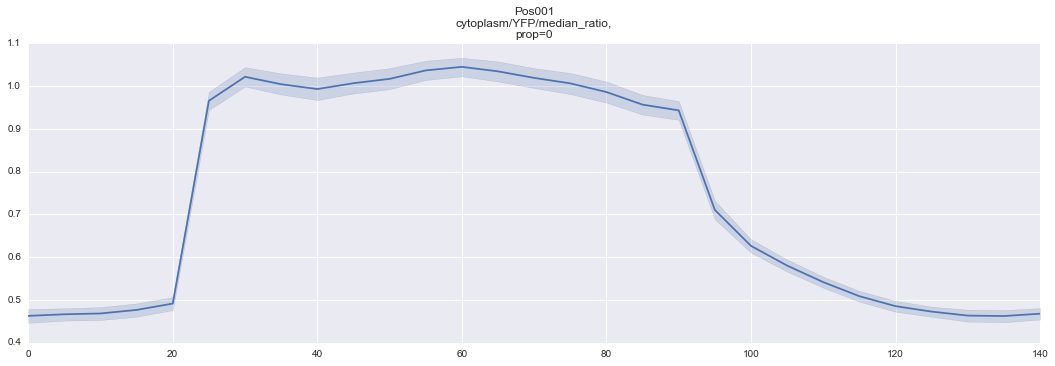

In [7]:
sites.set_state(['cytoplasm', 'YFP', 'median_ratio'])
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

You can see the cytoplasmic translocation of the JNK KTR at frame 5 when the cells are stimulated with anisomycin, followed by nuclear translocation at frame 18 when the cells are inhibited with JNK VIII inhibitor.  
This combination of activation and inactivation will provide a large dynamic range, helping robust parameter estimation. 

Again, we use $k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
Let's use frame 10 to 16 and frame 18 to the end for our activated and inhibited conditions, respectively. 

In [8]:
site = sites.Pos001
r_n_1 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][:, 10:17])
r_n_2 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][:, 18:])
r_c_1 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][:,10:17])
r_c_2 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][:, 18:])
estimated_k_v = (r_n_2 - r_n_1)/(r_c_1 - r_c_2)
print 'k_v is {0:1.2f}'.format(estimated_k_v)

k_v is 3.36


Using these conditions, we estimate $k_v$ to be 3.36

## Estimation of import and export rate constants: k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

Cytoplasmic translocation of the KTR happens because phosphorylation both decreases the nuclear export rate and increases the nuclear import rate. 
So now we need to find the rate constants for the import ($k_i$) and export ($k_e$) of phosphorylated ($k_p$) and unphosphorylated ($k_u$) reporters.

To estimate these constants, we utilize the fact that JNK KTR AA and EE mutants approximate the unphosphorylated and phosphorylated states of the wild-type JNK KTR, respectively. Since AA and EE mutants are not phosphorylated, we assume that k<sub>e/i</sub> for AA mutants is equal to k<sub>eu/iu</sub> and that k<sub>e/i</sub> for EE mutants is equal to k<sub>ep/ip</sub>.

In [9]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos004', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df_cleaned.npz')

Leptomycin B (LMB) is a potent inhibitor of nuclear export. The cells are treated with LMB at frame 3 and you see a decrease in nuclear export led to a net nuclear translocation.

[<matplotlib.text.Text at 0x1117cd7d0>, <matplotlib.text.Text at 0x111d49e50>]

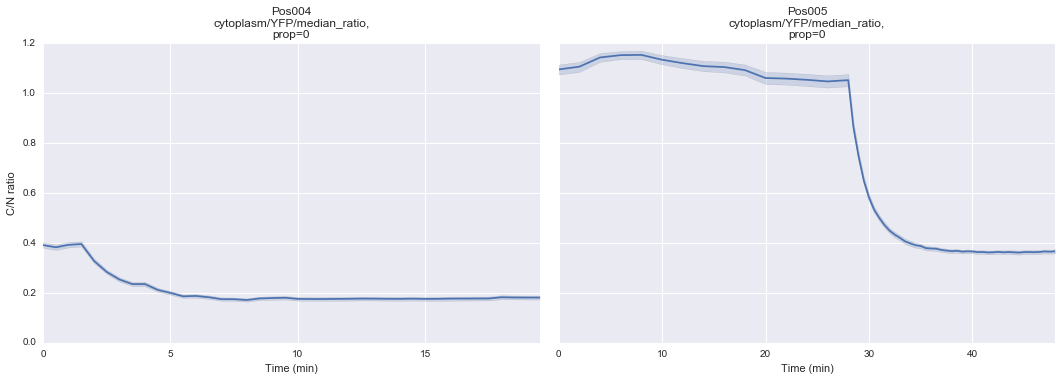

In [10]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_tsplot)
axes[0].set_ylabel('C/N ratio')
[ax.set_xlabel('Time (min)') for ax in axes]

In [11]:
aa_ratio = sites_mut.Pos004.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

The efficiency of LMB inhibition varies from cell-to-cell. This is expressed by parameter $h$; upon inhibition at time *t<sub>inh</sub>*, export rate changes from $k_e$ to $hk_e$.  

We use the following system of differential equations to decribe reporter concentration in the nucleus (r<sub>n</sub>) and cytoplasm (r<sub>c</sub>).

$\dfrac{dr_c}{dt} = -k_i  r_c + k_e  r_n$  
$\dfrac{dr_n}{dt} = k_v  k_i  r_c - k_v  k_e  r_n$

In [12]:
def ode_mutant_model(y, t, *args):
    k_v, k_i, k_e = args[0], args[1], args[2]
    r_c, r_n = y[0], y[1]
    d_r_c = -k_i * r_c + k_e * r_n
    d_r_n = k_v * k_i * r_c - k_v * k_e * r_n
    return [d_r_c, d_r_n]

The initial steady state of the system is $\dfrac{k_e}{k_i}$, and the steady state after the inhibition will be $\dfrac{hk_e}{k_i}$. 
We can use these values to estimate *h* for each cell.

In [13]:
h_aa, h_ee = [], []
for cell in aa_ratio:
    h_aa.append(np.mean(cell[30:])/np.mean(cell[:3]))
for cell in ee_ratio:
    h_ee.append(np.mean(cell[30:])/np.mean(cell[:12]))

We would like to find the parameters $h$, $k_e$ and $k_i$ such that the model reproduces the time series of the LMBB treatment experiment. Write a function that receives $h$, $k_e$ and $k_i$ and returns the predicted time series of the C/N ratio.

In [14]:
def calc_ts_sim_ratio(x, time, k_v, t_inh, h):
    ei_ratio = x[0]
    k_i = x[1]
    k_e = ei_ratio * k_i
    
    ini_r_c = 1.0
    ini_r_n = 1.0/ei_ratio
    params = (k_v, k_i, k_e)
    # Simulate before inhibition
    ts_pre_inh = odeint(ode_mutant_model, [ini_r_c, ini_r_n], time[time<t_inh], params, rtol=1e-4)
    r_pre_inh = np.array([i[0]/i[1] for i in ts_pre_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    params = (k_v, k_i, k_e * h)
    # Simulate after inhibition
    ts_post_inh = odeint(ode_mutant_model, [ts_pre_inh[-1, 0], ts_pre_inh[-1, 1]], time[time>=t_inh], params, rtol=1e-4)
    r_post_inh = np.array([i[0]/i[1] for i in ts_post_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    return np.concatenate((r_pre_inh, r_post_inh))

To begin with, run a simulation just for a single cell with an EE mutant reporter.  
Before stimulation, $\dfrac{k_e}{k_i} = \dfrac{r_c}{r_n}$.

In [15]:
bnds = ((1e-6, None), (1e-6, None))  # boundary for h, k_i and k_e
time_ee = np.concatenate((np.arange(0, 28, 2), np.arange(28, 48.5, 0.5)))
t_inh_ee = 27.5

cell_id = 2
first_cell = ee_ratio[cell_id, :]  # time-series of C/N ratio of a cell.

func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, h_ee[cell_id]) - first_cell)**2).sum()  # cost function
ret = minimize(func, x0=[np.mean(first_cell[:1]), 0.1], bounds=bnds, method='L-BFGS-B')  # run the optimization
est_ei_ratio, est_k_i = ret.x  # parameters
est_k_e = est_ei_ratio * est_k_i
print 'k_e and k_i are estimated to be {0:1.3f} and {1:1.3f} for this cell.'.format(est_k_e, est_k_i)

k_e and k_i are estimated to be 0.202 and 0.163 for this cell.


After estimating the parameters, we can compare the predicted time series and experimental time series for this cell.

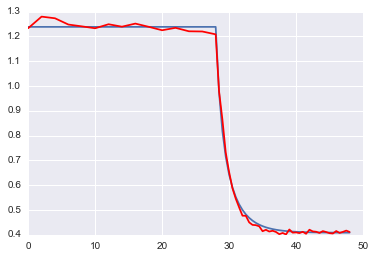

In [16]:
ts_pre_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee<=t_inh_ee],  (estimated_k_v, est_k_i, est_k_e), rtol=1e-4)
ts_post_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee>t_inh_ee],  (estimated_k_v, est_k_i, h_ee[cell_id] * est_k_e), rtol=1e-4)

plt.plot(time_ee, np.concatenate(([i[0]/i[1] for i in ts_pre_inh], [i[0]/i[1] for i in ts_post_inh])))
plt.hold(True)
plt.plot(time_ee, first_cell, 'r');

Now we expand this for all the cells in the experiement. 

In [18]:
param_ee_store = []
for cell, sc_h in zip(ee_ratio, h_ee):
    func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, sc_h) - cell)**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B', tol=1e-12)
    if ret.success:
        param_ee_store.append(ret.x)
est_k_ip = [i[1] for i in param_ee_store]
est_k_ep = [i[0]*i[1] for i in param_ee_store]

Repeat the process and run a simulation for all the cells with AA mutant reporters.  
Parameter estimation for AA mutants is more sensitive than EE mutants due to the reporter's small dynamic range.  

In [19]:
param_aa_store = []

time_aa = np.arange(0, 40) * 0.5 # /min, Imaged every 30 sec
t_inh_aa = 2.0   # /min, timing of inihibiton
for cell, sc_h in zip(aa_ratio, h_aa):
    func = lambda x: ((calc_ts_sim_ratio(x, time_aa, estimated_k_v, t_inh_aa, sc_h) - cell)**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B', tol=1e-12)
    if ret.success:
        param_aa_store.append(ret.x)

est_k_eu = [i[0]*i[1] for i in param_aa_store]
est_k_iu = [i[1] for i in param_aa_store]

k_iu:0.413	k_ip:0.155
k_eu:0.159	k_ep:0.173


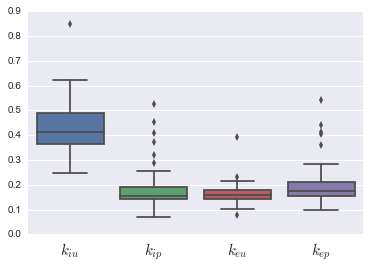

In [20]:
ax = sns.boxplot(data=[est_k_iu, est_k_ip, est_k_eu, est_k_ep])
ax.set_xticklabels(['$k_{iu}$', '$k_{ip}$', '$k_{eu}$', '$k_{ep}$'], fontsize=15);
print "k_iu:{0:1.3}\tk_ip:{1:1.3}\nk_eu:{2:1.3}\tk_ep:{3:1.3}".format(np.nanmedian(est_k_iu), np.nanmedian(est_k_ip), np.nanmedian(est_k_eu), np.nanmedian(est_k_ep))

As expected, you can see that the estimated import rate is larger for unphosphorylated reporters, whereas the export rate is larger for phosphorylated reporters.  
The combination of these effects causes the cytoplasmic translocation of KTRs upon phosphorylation.

## Estimation of dephosphorylation parameters: k<sub>d</sub> and K<sub>md</sub>

k<sub>d</sub> and K<sub>md</sub> are the maximum dephosphorylation rate and Michaelis-Menten constant of reporter dephosphorylation, respectively. Here we assume k<sub>d</sub> is equal in both the cytosol and nucleus.

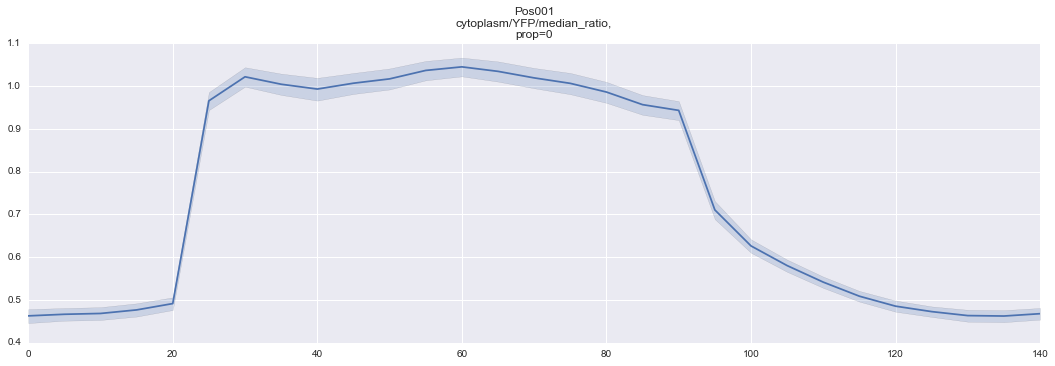

In [21]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
site = sites.Pos001

We fit $k_d$ and $K_{md}$ to a model such that it reproduces the decay of the C/N ratio after kinase inhibitor treatment at frame 18.
We assume that JNK inhibitor begins inhibition instantly after it is applied to the cells, and that the extent of inhibition varies from cell to cell. 

We are going to use the average import/export rate constants estimated in the previous section. First, make a dictionary containing the parameter set.

In [22]:
param_set = dict(k_v=estimated_k_v, 
                 k_iu=np.nanmedian(est_k_iu), k_eu=np.nanmedian(est_k_eu), 
                 k_ip=np.nanmedian(est_k_ip), k_ep=np.nanmedian(est_k_ep),
                 k_cat=k_cat, Km=Km, r_total=r_total)

Now make a model for the KTR system describing the phosphorylation, dephosphorylation, and nuclear-cytosolic shuttling of the KTR. 

In [23]:
def main_ode(y, t, p):
    """kin_c_func and kin_n_func are the functions that return the active kinase concentration at time t. 
    """
    c_u, n_u, c_p, n_p = y[0], y[1], y[2], y[3]

    k_v = p['k_v']
    k_iu, k_eu, k_ip, k_ep = p['k_iu'], p['k_eu'], p['k_ip'], p['k_ep']
    k_cat, Km, r_total = p['k_cat'], p['Km'], p['r_total']
    k_dc, k_dn, Kmd = p['k_d'], p['k_d'], p['Kmd']
    kin_c_func, kin_n_func = p['kin_c_func'], p['kin_n_func']

    d_c_u = -kin_c_func(t) * k_cat * c_u/(c_u + Km) + k_dc * c_p/(c_p + Kmd) - k_iu * c_u + k_eu * n_u
    d_n_u = -kin_n_func(t) * k_cat * n_u/(n_u + Km) + k_dn * n_p/(n_p + Kmd) + k_v * k_iu * c_u - k_v * k_eu * n_u
    d_c_p = kin_c_func(t) * k_cat * c_u/(c_u + Km) - k_dc * c_p/(c_p + Kmd) - k_ip * c_p + k_ep * n_p
    d_n_p = r_total - c_u - n_u/k_v - c_p - n_p/k_v
    return [d_c_u, d_n_u, d_c_p, d_n_p]

We assume the system is in steady state before inhibiton, thus at a given C/N ratio, we can calculate the reporter profile ($r_{cu}$, $r_{nu}$, $r_{cp}$, $r_{np}$) such that $dr/dt$ is 0.

Write a function that will calculate the reporter profile given an active kinase concentration.

In [24]:
def calc_rep_profile_at_steady_state(kin, pset):
    """At given kinase concentration and parameters,
    simulate the reporter profile (c_u, n_u, c_p, c_p)
    such that it minimizes sum of squared dy, assuming the pseudo-steady state.
    
    Output: reporter profile
    """
    ub = pset['r_total']
    pset['kin_c_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    pset['kin_n_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    x0 = [ub, 0, 0, 0]

    func = lambda y: (np.array(main_ode(y, 0, pset))**2).sum()
    ret = minimize(func, x0=x0, method='Powell', tol=1e-3)
    return ret.x

def calc_rcn_at_steady_state(kin, pset):
    """At given kinase concentration and parameters, simulate the C/N ratio
    such that it minimizes sum of squared dy, assuming the pseudo-steady state.
    """
    x = calc_rep_profile_at_steady_state(kin, pset)
    return (x[0] + x[2])/(x[1] + x[3])

In [25]:
KIN_MAX = 3.0
def inhibitor_ode(x, time, rcn_init, rcn_final, pset):
    pset['k_d'] = x[0]
    pset['Kmd'] = x[1]
    # Calculate kinase concentration at steady state such that it matches with given rcn
    kin_ini = estim_steady_state_kinase(rcn_init, pset, bnd_max=KIN_MAX)
    # At given kinase concentration, calculate reporter profile.
    y0 = calc_rep_profile_at_steady_state(kin_ini, pset)
    # At given rcn_final, calculate kinase concentration at the final steady state.
    kin_after_inh = estim_steady_state_kinase(rcn_final, pset, bnd_max=kin_ini)
    pset['kin_c_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    pset['kin_n_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    # At time 0, inihibition started. kinase is inactive so it follows kinase (rcn_final)
    # but reporter profile at time 0 follows y0. Calculate cytoplasmic to nuclear times series.
    ts = odeint(main_ode, y0, time, (pset, ), rtol=1e-4)
    return (ts[:, 0] + ts[:, 2])/(ts[:, 1] + ts[:, 3])

def estim_steady_state_kinase(rcn, pset, bnd_min=0, bnd_max=None):
    """Given C/N ratio at the steady state, return active kinase concentration.
    """
    func1 = lambda kin1: ((calc_rcn_at_steady_state(kin1, pset) - rcn)**2).sum()
    ret1 = minimize(func1, x0=[0.01], bounds=((bnd_min, bnd_max), ), tol=1e-4)
    return ret1.x[0]

FIXME: why we limit Kmd as r_total... can you add one sentence to reaosn it bette.r 

Estimating $k_d$ and $K_{md}$ with this model is a difficult task, as the possible solution space is large.  
For simplicity, we will fit with the population average time-series as opposed to each single-cell trace.  

We will first guess the initial values by looping over some parameter range in the model. Note, that we bound the upper limit of $K_{md}$ as $r_{total}$. 

In [26]:
# The estimation of the initial values.. 
med_rcn = np.nanmean(site.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
rcn_init = np.nanmean(med_rcn[18])
rcn_final = med_rcn[-1]
decay_rcn = med_rcn[18:]

time = np.arange(len(decay_rcn)) * 5  # every 5 min
func = lambda x: ((inhibitor_ode(x, time, rcn_init, rcn_final, param_set) - decay_rcn)**2).sum()  # cost function

# To avoid trapped in local solution, we will first estimate initial values by looping over in a log-scale.
kd_range, kmd_range = np.logspace(-2, 0, 5), np.logspace(-2, np.log10(param_set['r_total']), 5)

store = [np.Inf, np.Inf, np.Inf]
for kdi in kd_range:
    for kmdi in kmd_range:
        res = func([kdi, kmdi])
        if store[0] > res:
            store = [res, kdi, kmdi]
ini_kd, ini_kmd = store[1], store[2]
print ini_kd, ini_kmd

0.0316227766017 0.159054145753


Now we estimate $k_d$ and $K_{md}$ using the initial guesses we just estimated. 


The estimated k_d and Kmd for this cell is 0.030 and 0.160


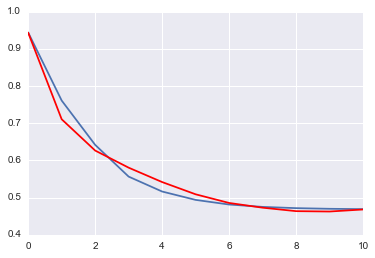

In [27]:
# The estimation of k_d and Kmd for all the single cells takes a time.
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: KIN_MAX - x[0]},
        {'type': 'ineq', 'fun': lambda x: param_set['r_total'] - x[1]})
ret = minimize(func, x0=[ini_kd, ini_kmd], constraints=cons, method='COBYLA', tol=1e-4)
est_k_d, est_Kmd = ret.x[0], ret.x[1]

param_set['k_d'] = est_k_d
param_set['Kmd'] = est_Kmd

plt.plot(inhibitor_ode([est_k_d, est_Kmd], time, rcn_init, rcn_final, param_set))
plt.hold(True)
plt.plot(decay_rcn, 'r')
print 'The estimated k_d and Kmd for this cell is {0:1.3f} and {1:1.3f}'.format(est_k_d, est_Kmd)

## Absolute kinase concentration

Now we have obtained all of the parameters we need to estimate absolute kinase concentration over time. 
First, plot a simulated relationship between the C/N ratio and active JNK at steady state.

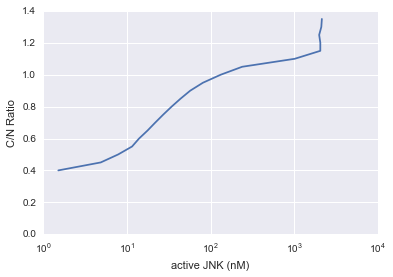

In [28]:
st = []
for i in np.arange(0, 1.4, 0.05):
    st.append(estim_steady_state_kinase(i, param_set) * 1000)  # in nM
plt.semilogx(st, np.arange(0, 1.4, 0.05))
plt.xlabel('active JNK (nM)')
plt.ylabel('C/N Ratio')

You can see that the simulation gets unstable when the amount of active JNK is above 1000 nM.  
Presumably, the model cannot extrapolate past the upper bound of training data, so we will constrain the upper limit of active JNK to this value in the later simulations.  

In [29]:
KIN_MAX = 1.0  # 1uM

Now, let's calculate the time-series of JNK stimulated with IL1$\beta$. 

In [30]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
sites_il1b.staged.new_file_name = 'merged.npz'
sites_il1b.merge_conditions()

Pos005: file_name is updated to merged.npz


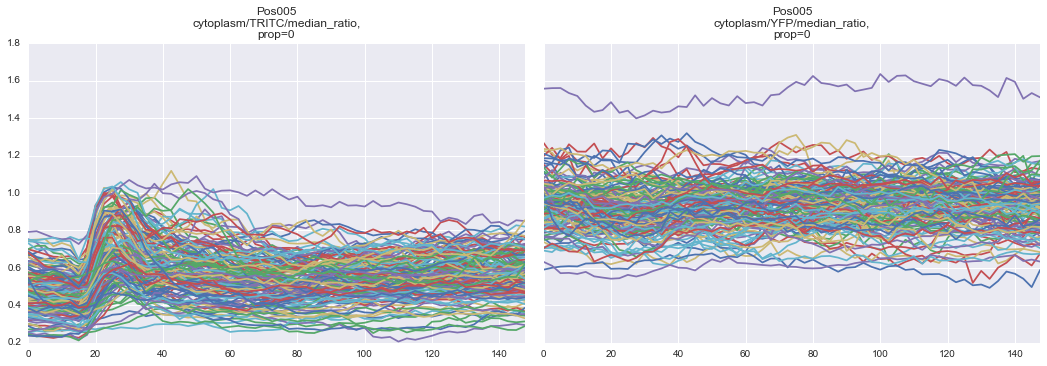

In [31]:
sites_il1b.set_state((['cytoplasm', 'TRITC', 'median_ratio'], ['cytoplasm', 'YFP', 'median_ratio']))
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_il1b.iterate(plot_all)

In this experiment, cells express the JNK KTR AE mutant (right) in addition to the JNK KTR (left).  
The variability observed in the JNK KTR AE mutant is a reflection of the noise in the endogenous export and import rates. We can use these data to correct for the variability in import and export in individual cells. 

For each cell, we calculate the average C/N ratio over time and then divide it by the average population C/N ratio. This value is *q*, the noise factor in export/import.  
We correct the mean value of the estimated $k_e$ and $k_i$ using $q$ for each cell. 

In [32]:
site_il1b = sites_il1b.Pos005
mean_yfp = np.nanmean(site_il1b.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
q_store = []
for cell in site_il1b.data['cytoplasm', 'YFP', 'median_ratio']:
    q_store.append(np.mean(cell/mean_yfp))

k_iu_sc, k_ip_sc, k_eu_sc, k_ep_sc = [], [], [], []
for q in q_store:
    k_iu_sc.append(np.nanmean(est_k_iu)/q)
    k_ip_sc.append(np.nanmean(est_k_ip)/q)
    k_eu_sc.append(np.nanmean(est_k_eu) * q)
    k_ep_sc.append(np.nanmean(est_k_ep) * q) 

Now let's start estimation with a single cell.

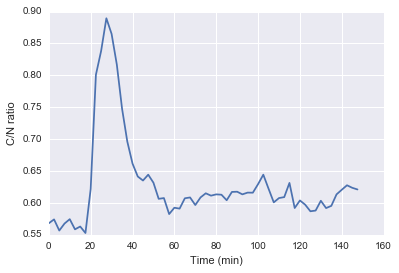

In [33]:
cell_id = 3
time = np.arange(0, 150, 2.5)  # in minute
single_rcn = site_il1b.data['cytoplasm', 'TRITC', 'median_ratio'][cell_id, :]
plt.plot(time, single_rcn)
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

First, to reduce the complexity of parameter estimation, we assume that time-course of active JNK, as well as C/N ratio with IL1-$\beta$ treatment, can be modeled using the trapezoid function below.    
This part might not be necessary but reduces the calculation cost. (CITATION)
<img src="../../data/trapezoid.jpg" width="300">

To first make a initial guess, we also fit the time-series with the trapezoid function to obtain the approximate time for t1 to t4. 

In [34]:
def trapezoid_func(t, ct1, ct2, ct3, ct4, c1, c2, c3):
    """Trapezoid function.
    ct1 = t1
    ct2 = t1 + t2
    ct3 = t1 + t2 + t3
    ct4 = t1 + t2 + t3 + t4
    
    """
    if t <= ct1:
        return c1
    elif (t > ct1) and (t <= ct2):
        return c1 + (c2 - c1) * (t-ct1)/(ct2-ct1)
    elif (t > ct2) and (t <= ct3):
        return c2
    elif (t > ct3) and (t <= ct4):
        return c2 - (c2 - c3) * (t-ct3)/(ct4-ct3)
    elif t > ct4:
        return c3

Now, since we assume the data can be fit with the trapezoid function, we would like to capture the dynamics of first peak (mostly ~50 min) in particular.  
Thus, we put some emphasis on the fitting results before 50 min in the following cost function. This makes fitting to noisy data more robust.

In [35]:
def trapezoid_err(params, t, y, w=5, tw=50):
    """cost function for trapezoid fitting.
    w is picked ad hoc."""
    weights = np.ones(len(t))
    weights[t <= tw] = w
    y_p = np.zeros(y.shape)
    for num, ti in enumerate(t):
        y_p[num] = trapezoid_func(np.float(ti)/t.max(), *params)
    return ((y - y_p)**2 * weights).sum()

In [36]:
def fit_trapezoid(t, y, p0=None, tbuf=[0.05, 0.05, 0.05]):
    if p0 is None:
        p0 = [0.2, 0.4, 0.6, 0.8, y[0], y.max(), y[-1]]
    # This is the constraints for trapezoid parameters.
    cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0] - tbuf[0]},  # t1 < t2
            {'type': 'ineq', 'fun': lambda x:  x[2] - x[1] - tbuf[1]},  # t2 < t3
            {'type': 'ineq', 'fun': lambda x:  x[3] - x[2] - tbuf[2]},  # t3 < t4
            {'type': 'ineq', 'fun': lambda x:  x[5] - x[4]},  # c1 < c2
            {'type': 'ineq', 'fun': lambda x:  x[5] - x[6]},  # c3 < c2
            {'type': 'ineq', 'fun': lambda x:  x})  # non-negative parameters
    bnds = ((0, 1), ) * 4 + ((y.min(), y.max()), ) * 3
    fun = partial(trapezoid_err, t=t, y=y)
    res = minimize(fun, p0, constraints=cons, bounds=bnds, tol=1e-12, options=dict(max_iter=10000))
    # convert Ts from relative to absolute time.
    Ts = np.interp(res.x[:4], np.linspace(0, 1, len(t)), t)
    return np.concatenate((Ts, res.x[4:]))

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


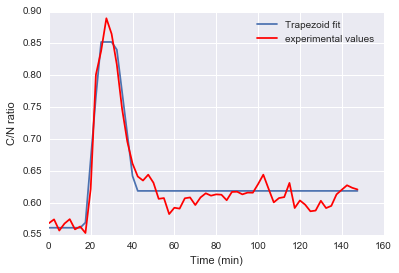

In [37]:
ct1, ct2, ct3, ct4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
kin_func = lambda t: np.interp(t, [ct1, ct2, ct3, ct4, time[-1]], [c1, c2, c2, c3, c3])
plt.plot(time, kin_func(time))
plt.hold(True)
plt.plot(time, single_rcn, 'r')
plt.legend(['Trapezoid fit', 'experimental values'])
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

The fit looks good and we have acquired initial values for t1 to t4.  
Note that t1 to t4 are normalized by the last time point to have a scale from 0 to 1.

In [38]:
def normt1_to_ct1(rt1, rt2, rt3, rt4, time):
    """convert normalized t1 to cumulative time."""
    ct1 = rt1 * time[-1]
    ct2 = (rt1 + rt2) * time[-1]
    ct3 = (rt1 + rt2 + rt3) * time[-1]
    ct4 = (rt1 + rt2 + rt3 + rt4) * time[-1]
    return ct1, ct2, ct3, ct4

def ct1_to_normt1(ct1, ct2, ct3, ct4, time):
    """convert cumulative time to normalized t1."""
    t1 = ct1/time[-1]
    t2 = (ct2 - ct1)/time[-1]
    t3 = (ct3 - ct2)/time[-1]
    t4 = (ct4 - ct3)/time[-1]
    return t1, t2, t3, t4

ini_t1, ini_t2, ini_t3, ini_t4 = ct1_to_normt1(ct1, ct2, ct3, ct4, time)  # initial values

In [39]:
def kinase_dynamics_ode(kins, time, pset, k1):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k2, k3, t1, t2, t3, t4 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    ct1, ct2, ct3, ct4 = normt1_to_ct1(t1, t2, t3, t4, time)
    t_kins = [ct1, ct2, ct3, ct4, time[-1]]
    
    pset['kin_c_func'] = lambda t: np.interp(t, t_kins, [k1, k2, k2, k3, k3])
    pset['kin_n_func'] = lambda t: np.interp(t, t_kins, [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ))
    return ts

def rcn_dynamics_ode(kins, time, pset, k1):
    rep = kinase_dynamics_ode(kins, time, pset, k1)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

In [40]:
# Set the corrected import and export rate constants for this cell to the param_set.
param_set['k_iu'] = k_iu_sc[cell_id]
param_set['k_ip'] = k_ip_sc[cell_id]
param_set['k_eu'] = k_eu_sc[cell_id]
param_set['k_ep'] = k_ep_sc[cell_id]
kin_ini = estim_steady_state_kinase(single_rcn[0], param_set, bnd_max=KIN_MAX)  
kin_fin = estim_steady_state_kinase(c3, param_set, bnd_max=KIN_MAX)

In [41]:
func = lambda x: ((rcn_dynamics_ode(x, time, param_set, kin_ini) - single_rcn)**2).sum()

In [42]:
bnds = ((0, 1), (0, 1), (0, ini_t1), (0, ini_t2), (0, ini_t3), (0, ini_t4))
ret = minimize(func, x0=(kin_fin*2, kin_fin, ini_t1, ini_t2, ini_t3, ini_t4), bounds=bnds, method='L-BFGS-B')

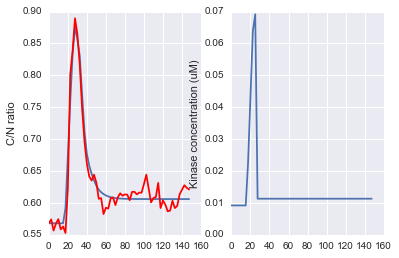

In [43]:
ax1 = plt.subplot(1,2,1)
h1 = plt.plot(time, rcn_dynamics_ode(ret.x, time, param_set, kin_ini))
plt.hold(True)
h2 = plt.plot(time, single_rcn, 'r')
ax1.set_ylabel('C/N ratio')

ax2 = plt.subplot(1,2,2)

ct1, ct2, ct3, ct4 = normt1_to_ct1(ret.x[2], ret.x[3], ret.x[4], ret.x[5], time)
kin_ts = np.interp(time, [ct1, ct2, ct3, ct4, time[-1]], [kin_ini, ret.x[0], ret.x[0], ret.x[1], ret.x[1]])
plt.plot(time, kin_ts)
ax2.set_ylabel('Kinase concentration (uM)')

In [44]:
# Put the steps above into this.
def estim_kin_ts(time, single_rcn, pset, k_iu, k_ip, k_eu, k_ep):
    ct1, ct2, ct3, ct4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
    pset['k_iu'] = k_iu
    pset['k_ip'] = k_ip
    pset['k_eu'] = k_eu
    pset['k_ep'] = k_ep
    kin_ini = estim_steady_state_kinase(c1, pset, bnd_max=KIN_MAX)
    kin_fin = estim_steady_state_kinase(c3, pset, bnd_max=KIN_MAX)
    
    func = lambda x: ((rcn_dynamics_ode(x, time, param_set, kin_ini) - single_rcn)**2).sum()
    bnds = ((0, 1), (0, 1), (0, ini_t1), (0, ini_t2), (0, ini_t3), (0, ini_t4))
    ret = minimize(func, x0=(kin_fin*3, kin_fin, ini_t1, ini_t2, ini_t3, ini_t4), bounds=bnds, method='L-BFGS-B', tol=1e-4)

    estim_rcn = rcn_dynamics_ode(ret.x, time, param_set, kin_ini)
    ct1, ct2, ct3, ct4 = normt1_to_ct1(ret.x[2], ret.x[3], ret.x[4], ret.x[5], time)
    estim_kin = np.interp(time, [ct1, ct2, ct3, ct4, time[-1]], [kin_ini, ret.x[0], ret.x[0], ret.x[1], ret.x[1]])
    return estim_rcn, estim_kin

Simulate for five cells.

0 estimating...


/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


1 estimating...
2 estimating...
3 estimating...
4 estimating...


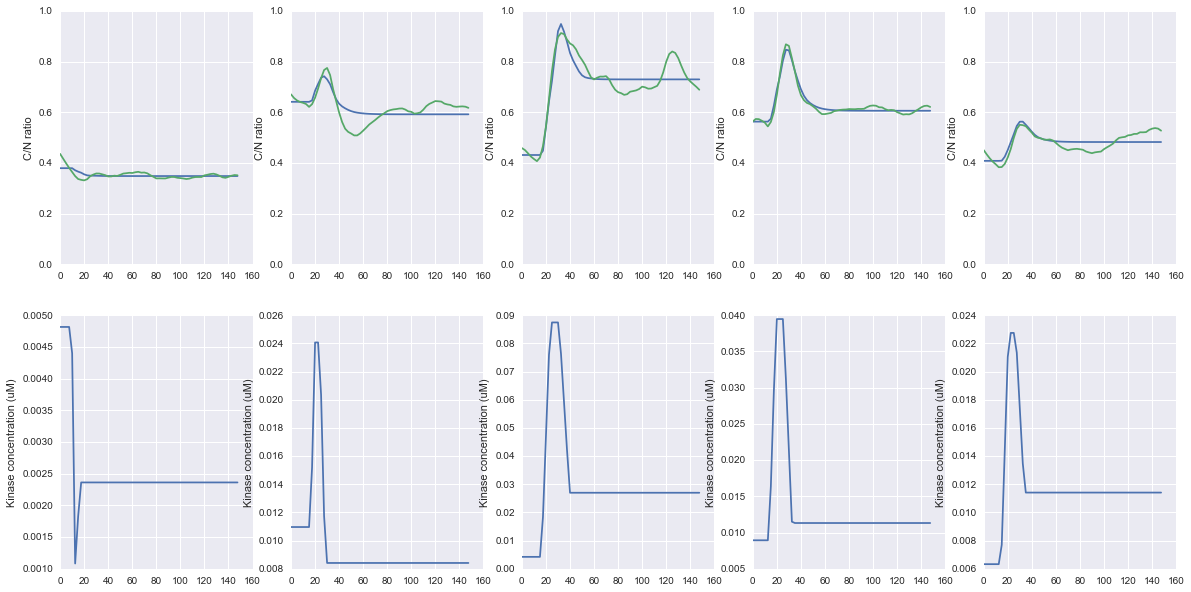

In [45]:
plt.figure(figsize=(20, 10))
median_ratio = site_il1b.data['cytoplasm', 'TRITC', 'median_ratio']
median_ratio = savgol_filter(median_ratio, window_length=9, polyorder=3, axis=1)  # smoothing
cell_ids = range(5)
for num, cell_id in enumerate(cell_ids):
    single_rcn = median_ratio[cell_id]
    print '{0} estimating...'.format(cell_id)
    estim_rcn, estim_kin = estim_kin_ts(time, single_rcn, param_set,  k_iu_sc[cell_id], k_ip_sc[cell_id], k_eu_sc[cell_id], k_ep_sc[cell_id])
    ax1 = plt.subplot(2, 5, num+1)
    plt.plot(time, estim_rcn, time, single_rcn)
    ax1.set_ylabel('C/N ratio')
    ax1.set_ylim([0, 1])
    ax2 = plt.subplot(2, 5, num+1+5)
    plt.plot(time, estim_kin)
    ax2.set_ylabel('Kinase concentration (uM)')

The following part, the estimation for all the cells, will take a time (~30 min).

In [62]:
# Store estimated C/N ratio and estimated active JNK in store
store = []
cell_ids = range(median_ratio.shape[0])
for num, cell_id in enumerate(cell_ids):
    single_rcn = median_ratio[cell_id]
#     print '{0} estimating...'.format(cell_id)
    estim_rcn, estim_kin = estim_kin_ts(time, single_rcn, param_set,  k_iu_sc[cell_id], k_ip_sc[cell_id], k_eu_sc[cell_id], k_ep_sc[cell_id])    
    store.append((single_rcn, estim_rcn, estim_kin))

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


1456.09159613


In [47]:
# get rid of those did not fit well.
cleaned_data = [i for i in store if (np.abs(i[1] - i[0])).sum() < 2.5]

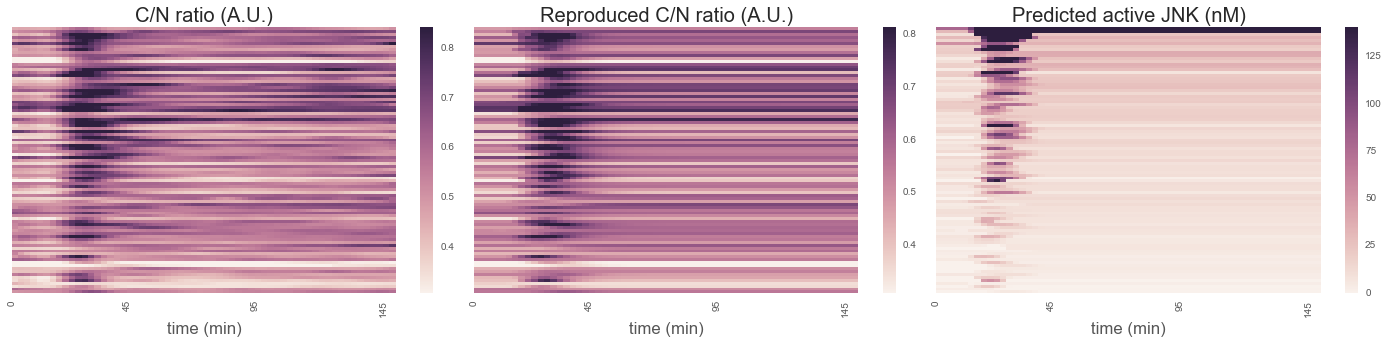

In [59]:
idx = np.argsort(-np.sum([i[2] for i in cleaned_data], axis=1))
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes.tolist()
sns.heatmap([cleaned_data[i][0] for i in idx], robust=True, ax=axes[0])
sns.heatmap([cleaned_data[i][1] for i in idx], robust=True, ax=axes[1])
sns.heatmap([cleaned_data[i][2]*1000 for i in idx], robust=True, ax=axes[2])
[ax.set_title(i) for ax, i in zip(axes, ('C/N ratio (A.U.)', 'Reproduced C/N ratio (A.U.)', 'Predicted active JNK (nM)'))];
[ax.set_yticklabels("") for ax in axes];
[ax.set_xticks([0, 18, 38, 58]) for ax in axes];
[ax.set_xticklabels([int(time[0]), int(time[18]), int(time[38]), int(time[58])]) for ax in axes];
[ax.set_xlabel("time (min)") for ax in axes];
fig.tight_layout()
# fig.savefig('heatmap.svg', format='svg', dpi=1200)